# Final Project

# *1C Company* - Predict Future Sales

**Motivation**

This challenge serves as final project for the Coursera course "How to win a data science competition". In this competition I will work with a challenging time-series dataset consisting of daily sales data. The sales data is kindly provided by one of the largest Russian software firms - 1C Company. 

The task is to **predict the total amount of products sold in every shop for the test set in the next month**. 

Submissions are evaluated by **root mean squared error** (RMSE). True target values are clipped into [0,20] range.

Source: https://www.kaggle.com/c/competitive-data-science-predict-future-sales/overview

## Table of contents

###  [1. Importing data](#Tag1)
&nbsp;&nbsp;&nbsp;[1.1 Import Generic Libraries](#Tag2.1)  
&nbsp;&nbsp;&nbsp;[1.2 Import Raw csv files](#Tag2.2)  
###  [2. Understanding Features, cleaning data](#Tag2)
&nbsp;&nbsp;&nbsp;[2.1 Understanding BasicsData Types](#Tag2.1)  
&nbsp;&nbsp;&nbsp;[2.2 Extracting text features from category and shops](#Tag2.2)  
&nbsp;&nbsp;&nbsp;[2.3 Extracting numeric features and cleaning](#Tag2.3)         
###  [3. EDA and CV dataset preparation](#Tag3)
&nbsp;&nbsp;&nbsp;[3.1 Visualize general trends](#Tag3.1)
&nbsp;&nbsp;&nbsp;[3.2 Data Leakage](#Tag3.2)
&nbsp;&nbsp;&nbsp;[3.3 Construct training set](#Tag3.3)
&nbsp;&nbsp;&nbsp;[3.4 Add numeric lag features](#Tag3.4)
&nbsp;&nbsp;&nbsp;[3.5 mean encoding categorical features](#Tag3.5)
###  [4. Modeling](#Tag4)   
&nbsp;&nbsp;&nbsp;[4.1 Model selection, train and validation strategies](#Tag4.1)   
&nbsp;&nbsp;&nbsp;[4.2 LightGBM](#Tag4.2)  
&nbsp;&nbsp;&nbsp;[4.3 Linear model](#Tag4.3)
&nbsp;&nbsp;&nbsp;[4.3 catboost](#Tag4.4)
&nbsp;&nbsp;&nbsp;[4.4 Ensembling](#Tag4.5)  
###  [5. Conclusion](#Tag5)       
&nbsp;&nbsp;&nbsp;  

# 1. Importing Data <a name="Tag1"></a>

### 1.1 Import Generic Librarie <a name="Tag1.1"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
# below are housekeeping, timing ,etc kits
import pickle
import gc
import re
import string 
import tqdm
import os

# below are modeling 
import sklearn
import lightgbm as lgb
import catboost

# below are NLP packages for text and google translate to translate russian into English
# $pip install nltk
# $pip install googletrans
# please run in terminals if you don't have them
# below are basics data processing/visualization
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
import gensim
import googletrans
import re

# Below are the specific libraries in the packages
from math import sqrt
from numpy import loadtxt
from itertools import product
from tqdm import tqdm,tqdm_notebook
from matplotlib import pyplot
from googletrans import Translator
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, MinMaxScaler,StandardScaler
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics import accuracy_score,mean_squared_error,r2_score
from sklearn.model_selection import KFold, train_test_split #StratifiedKFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso, SGDRegressor
from sklearn.decomposition import NMF #PCA, TruncatedSVD, 
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
#from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic

from nltk.tokenize import word_tokenize
from nltk.tokenize import MWETokenizer
from gensim.models import Word2Vec
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
#from nltk.stem import LancasterStemmer   # DO NOT USE- not reliable in this application
#stemmer= LancasterStemmer()
from itertools import tee, islice
from collections import Counter
from googletrans import Translator

for p in [np, pd, sklearn, lgb]:
    print (p.__name__, p.__version__)

# downcast variables to save memory
def downcast_dtypes(df):
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols = [c for c in df if df[c].dtype in ["int64", "int32"]]
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols] = df[int_cols].astype(np.int16)
    return df

# get most frequent words
def get_top_n_words(corpus, n=None):
    """
    List the top n words in a vocabulary according to occurrence in a text corpus.
    get_top_n_words(["I love Python", "Python is a language programming", "Hello world", "I love the world"]) -> 
    # https://gist.github.com/CristhianBoujon/c719ba2287a630a6d3821d37a9608ac8
    """
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

# get ngrams
def ngrams(lst, n):
  tlst = lst
  while True:
    a, b = tee(tlst)
    l = tuple(islice(a, n))
    if len(l) == n:
      yield l
      next(b)
      tlst = b
    else:
        if len(l)==1:
          yield lst
          tlst = lst
          break
        else:
          break
 # from https://stackoverflow.com/questions/12488722/counting-bigrams-pair-of-two-words-in-a-file-using-python
 # with modifications to trap errors in case sentence has only 1 word

def duplicate_removal(w):
    word_list = []
    [word_list.append(s) for s in w if s not in word_list]
    return word_list
#https://www.engineeringbigdata.com/python-exercise-10-remove-duplicate-words-with-user-input/   this removes duplicated words in a sentence

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ivan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ivan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Ivan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


numpy 1.21.2
pandas 1.3.3
sklearn 1.0
lightgbm 3.3.0


### 1.2 Import Raw CSV Files <a name="Tag1.2"></a> 

In [2]:
### get raw data path from json header, then load all the raw data
!pip install pandas
from datetime import datetime
import pandas as pd
import json
settings = json.load(open('settings.json'))
settings
# read csv
item_categories = pd.read_csv(settings["DATA_DIR"] + 'item_categories.csv')
items = pd.read_csv(settings["DATA_DIR"] + 'items.csv')
shops = pd.read_csv(settings["DATA_DIR"] + 'shops.csv')
sales_train = pd.read_csv(settings["TRAIN_DATA_PATH"],
                          parse_dates=['date'],
                          date_parser=lambda x: datetime.strptime(x, '%d.%m.%Y'))
test = pd.read_csv(settings["TEST_DATA_PATH"])


You should consider upgrading via the 'C:\Users\Ivan\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


# 2. Understanding Features, cleaning data

### 2.1 Understanding BasicsData Types <a name="Tag2.1"></a> 
Here I use info() and head() methods to examine the loaded 4 files, to identify their size and feature types

Data fields description:
ID - an Id that represents a (Shop, Item) tuple within the test set
shop_id - unique identifier of a shop
item_id - unique identifier of a product
item_category_id - unique identifier of item category
date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
date - date in format dd/mm/yyyy
item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
item_price - current price of an item
item_name - name of item
shop_name - name of shop
item_category_name - name of item category

In [3]:
print(shops.head(5))
shops.info()
print('unique shops:')
print(shops.nunique())

                        shop_name  shop_id
0   !Якутск Орджоникидзе, 56 фран        0
1   !Якутск ТЦ "Центральный" фран        1
2                Адыгея ТЦ "Мега"        2
3  Балашиха ТРК "Октябрь-Киномир"        3
4        Волжский ТЦ "Волга Молл"        4
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   shop_name  60 non-null     object
 1   shop_id    60 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB
unique shops:
shop_name    60
shop_id      60
dtype: int64


In [4]:
print(items.head(5))
items.info()
print('unique items:')
print(items.nunique())

                                           item_name  item_id  \
0          ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0   
1  !ABBYY FineReader 12 Professional Edition Full...        1   
2      ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2   
3    ***ГОЛУБАЯ ВОЛНА  (Univ)                      D        3   
4        ***КОРОБКА (СТЕКЛО)                       D        4   

   item_category_id  
0                40  
1                76  
2                40  
3                40  
4                40  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   item_name         22170 non-null  object
 1   item_id           22170 non-null  int64 
 2   item_category_id  22170 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 519.7+ KB
unique items:
item_name           22170
item_id             22170
item_category_id     

In [5]:
print(item_categories.head(5))
item_categories.info()
print('unique item categories:')
print(item_categories.nunique())

        item_category_name  item_category_id
0  PC - Гарнитуры/Наушники                 0
1         Аксессуары - PS2                 1
2         Аксессуары - PS3                 2
3         Аксессуары - PS4                 3
4         Аксессуары - PSP                 4
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   item_category_name  84 non-null     object
 1   item_category_id    84 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ KB
unique item categories:
item_category_name    84
item_category_id      84
dtype: int64


In [6]:
print(sales_train.head(5))
sales_train.info()
print('unique sales table objects:')
print(sales_train.nunique())

        date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0 2013-01-02               0       59    22154      999.00           1.0
1 2013-01-03               0       25     2552      899.00           1.0
2 2013-01-05               0       25     2552      899.00          -1.0
3 2013-01-06               0       25     2554     1709.05           1.0
4 2013-01-15               0       25     2555     1099.00           1.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   date_block_num  int64         
 2   shop_id         int64         
 3   item_id         int64         
 4   item_price      float64       
 5   item_cnt_day    float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB
unique sales table objects:
date               1034
date_block_num       34
shop_id        

In [7]:
print(test.head(5))
test.info()
print('unique test header objects:')
print(test.nunique())

   ID  shop_id  item_id
0   0        5     5037
1   1        5     5320
2   2        5     5233
3   3        5     5232
4   4        5     5268
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   ID       214200 non-null  int64
 1   shop_id  214200 non-null  int64
 2   item_id  214200 non-null  int64
dtypes: int64(3)
memory usage: 4.9 MB
unique test header objects:
ID         214200
shop_id        42
item_id      5100
dtype: int64


### Based on the above codes, we learned that there are 60 unique shops, 84 unique itemcategories, and 22170 possible items. The main training set csv file should be sales_train, and it contains 21807 out of 22170 possible items
### the training set contains 2.9million objects, include 60/60 unique shops, and 21807/22170 unique items, and unknown amount of unique categories (to be explored further)
### on the other hand, the test data set contains 214k unique objects, contains 42/60 unique shops, and 5100/22170 unique items. Whether the shop_id , item_id in the test set follows similar distribution as train set needs to be explored. 
### Finally there are three text features : item_category_name, item_name and shop_name. Rest of the features are numerical. 

### 2.2 Extracting text features from category and shops <a name="Tag2.2"></a> 
Among 3 text features:  item_name, shop_name and item_category_name, and item_name has 20K+ unique objects, while the other two has less than 100 objects for each
we will leave item_name alone and do not extract categorical/numeric feature from it. We will only perform text feature extraction on the other smaller features (shop_name, and item_category_name)
Let's begin by defining a pipeline to convert russian text features to English, then perform bag-of-words to separate text,then TF-IDF to extract frequency related numeric features

In [8]:
# Setting up text - to - numeric - feature extraction code
# These are the routine customized methods for processing . here since categorical features for shop_name and category_name were less than 100,
# one can run these without much performance issues. I do not recommend using this for item_names as it has 22170 unique objects


# get most frequent words
def get_top_n_words(corpus, n=None):
    """
    List the top n words in a vocabulary according to occurrence in a text corpus.
    get_top_n_words(["I love Python", "Python is a language programming", "Hello world", "I love the world"]) -> 
    # https://gist.github.com/CristhianBoujon/c719ba2287a630a6d3821d37a9608ac8
    """
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

# get ngrams
def ngrams(lst, n):
  tlst = lst
  while True:
    a, b = tee(tlst)
    l = tuple(islice(a, n))
    if len(l) == n:
      yield l
      next(b)
      tlst = b
    else:
        if len(l)==1:
          yield lst
          tlst = lst
          break
        else:
          break
 # from https://stackoverflow.com/questions/12488722/counting-bigrams-pair-of-two-words-in-a-file-using-python
 # with modifications to trap errors in case sentence has only 1 word

def duplicate_removal(w):
    word_list = []
    [word_list.append(s) for s in w if s not in word_list]
    return word_list
#https://www.engineeringbigdata.com/python-exercise-10-remove-duplicate-words-with-user-input/   this removes duplicated words in a sentence

# google translate from Russian to English
tokenizer = MWETokenizer()
def get_ngrams(text,n):
    n_grams = ngrams(tokenizer.tokenize((text).split()), n)
    return [ ' '.join(grams) for grams in n_grams]
    
def text_cleaning(text_df):
    # process the text in this mini routine
	# step1: translate using google translate, then lower-case it
	# step2: lemmatize , gaming-game, xbox 360 with underscores
	# step3: remove dash, replace by underscores for two-words; then tokenize
	# step4: stem words (optional)
    tokenizer = MWETokenizer()
    tokenizer.add_mwe(('xbox','one'))
    tokenizer.add_mwe(('xbox','360'))
    unwantedtokens=[':',',','(',')','-','.','!','/']
    translator = Translator()
    for sentence in range(text_df.index.stop):
        temp=translator.translate(text_df[sentence],dest='en')
        testb=temp.text
        testb=testb.lower()
        del temp
        # change gaming to game, blue-ray to blue_ray(to make sure it detect it as one word)
        temp=testb.replace('ing', 'e') 
        testb=temp
        del temp
        # finished translation, then merge xbox and 360, xbox and one
        testb=' '.join(tokenizer.tokenize(testb.split()))
        ngram2=get_ngrams(testb,2)
        # make xbox_360 and x_box_one etc
        testb=(" ").join(ngram2)   
        # remove tokens, then remove duplicates, lemmatize and stem (stem is not implemented today)
        text_tokens = word_tokenize(testb)
        tokens_without_sw = [word for word in text_tokens if not word in stopwords.words()]
        filtered_sentence = [word for word in tokens_without_sw if not word in unwantedtokens]
        clean_sentence=" ".join(duplicate_removal(filtered_sentence))
        word_list = nltk.word_tokenize(clean_sentence)
        lemmatized_sentence = ' '.join([lemmatizer.lemmatize(w) for w in word_list])
        temp=lemmatized_sentence.replace('-', '_')  
        # change blue-ray to blue_ray to make sure it is treated as one word; since the stand-alone '-' has been removed, in-words '-' should be converted to '_'
        stemmed_sentence=temp
        del temp
        #stemmed_sentence= stemmer.stem(lemmatized_sentence)
        text_df[sentence]=stemmed_sentence
    return text_df

def plot_top_words(text_df,num_top_words):
    common_words = get_top_n_words(text_df, num_top_words)
    # picked top 40 words, because 40 will start to have common_words with minimum frequency of 1 - trivial solution
    # you can modify it and pass it as argument instead
    for word, freq in common_words:
        print(word, freq)
    # for 'top words'. 
    keywords,frequency=zip(*common_words)
    fig, ax = plt.subplots()
    fig.set_size_inches(9,9)
    plt.title('keywords and frequency of appearance ')
    y_pos = np.arange(len(keywords))
    plt.barh(y_pos, frequency)
    plt.yticks(y_pos, keywords)
    plt.show()
    return

def text_tfidf_num(text_df):
    countvectorizer = CountVectorizer(analyzer= 'word', stop_words='english')
    tfidfvectorizer = TfidfVectorizer(analyzer='word',stop_words= 'english')
    count_wm = countvectorizer.fit_transform(text_df)
    tfidf_wm = tfidfvectorizer.fit_transform(text_df)
    count_tokens = countvectorizer.get_feature_names()
    tfidf_tokens = tfidfvectorizer.get_feature_names()
    df_countvect = pd.DataFrame(data = count_wm.toarray(),columns = count_tokens)
    df_tfidfvect = pd.DataFrame(data = tfidf_wm.toarray(),columns = tfidf_tokens)
    print("Count Vectorizer\n")
    print(df_countvect.head(5))
    print("\nTD-IDF Vectorizer\n")
    print(df_tfidfvect.head(5))
    return df_tfidfvect

C:\Users\Ivan\AppData\Local\Temp/ipykernel_7412/3849403723.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_df[sentence]=stemmed_sentence


game 24
book 13
gift 13
accessory 8
digit 8
console 8
music 7
program 6
pc 5
payment 5
card 5
cinema 5
edition 4
ps2 3
ps3 3
ps4 3
psp 3
psvita 3
xbox_360 3
xbox_one 3
blu_ray 3
audiobooks 3
1c 3
literature 3
service 3
ticket 2
mac 2
live 2
number 2
figure 2
postcard 2
production 2
cd 2
board 2
souvenir 2
home 2
office 2
clean 2
medium 2
headset 1


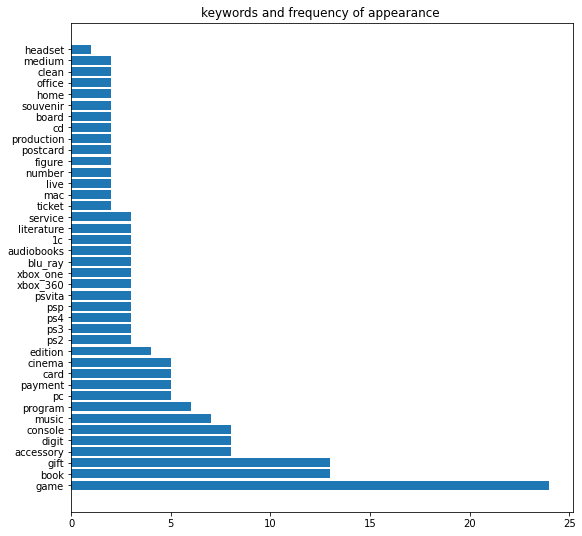

Count Vectorizer

   1c  3d  4k  accessory  additional  album  android  artbooks  attribute  \
0   0   0   0          0           0      0        0         0          0   
1   0   0   0          1           0      0        0         0          0   
2   0   0   0          1           0      0        0         0          0   
3   0   0   0          1           0      0        0         0          0   
4   0   0   0          1           0      0        0         0          0   

   audiobooks  ...  sticker  ticket  toy  traine  video  vinyl  window  \
0           0  ...        0       0    0       0      0      0       0   
1           0  ...        0       0    0       0      0      0       0   
2           0  ...        0       0    0       0      0      0       0   
3           0  ...        0       0    0       0      0      0       0   
4           0  ...        0       0    0       0      0      0       0   

   xbox_360  xbox_one  игры  
0         0         0     0  
1         0   

C:\Users\Ivan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [9]:
# First let's convert item_category text to word frequency
clean_cat_name=text_cleaning(item_categories.item_category_name)
plot_top_words(clean_cat_name,40)
item_cat_num=text_tfidf_num(clean_cat_name)

In [10]:
# # test code secton, commented out 
# tokenizer = MWETokenizer()
# tokenizer.add_mwe(('xbox','one'))
# tokenizer.add_mwe(('xbox','360'))
# unwantedtokens=[':',',','(',')','-','.','!','/']
# translator = Translator()

# text_df=item_categories.item_category_name

# sentence=18
# print(text_df[sentence])
# temp=translator.translate(text_df[sentence],dest='en')
# testb=temp.text
# print(testb)
# testb=testb.lower()

# del temp
# # change gaming to game, blue-ray to blue_ray(to make sure it detect it as one word)
# temp=testb.replace('ing', 'e') 
# testb=temp
# del temp
# # finished translation, then merge xbox and 360, xbox and one
# testb=' '.join(tokenizer.tokenize(testb.split()))
# ngram2=get_ngrams(testb,2)
# # make xbox_360 and x_box_one etc
# testb=(" ").join(ngram2)   
# # remove tokens, then remove duplicates, lemmatize and stem (stem is not implemented today)
# text_tokens = word_tokenize(testb)
# tokens_without_sw = [word for word in text_tokens if not word in stopwords.words()]
# filtered_sentence = [word for word in tokens_without_sw if not word in unwantedtokens]
# clean_sentence=" ".join(duplicate_removal(filtered_sentence))
# word_list = nltk.word_tokenize(clean_sentence)
# lemmatized_sentence = ' '.join([lemmatizer.lemmatize(w) for w in word_list])
# temp=lemmatized_sentence.replace('-', '_')  
# # change blue-ray to blue_ray to make sure it is treated as one word; since the stand-alone '-' has been removed, in-words '-' should be converted to '_'
# stemmed_sentence=temp
# del temp
# #stemmed_sentence= stemmer.stem(lemmatized_sentence)
# text_df[sentence]=stemmed_sentence

# print(testb)
# print(stemmed_sentence)

game 24
book 13
gift 13
accessory 8
digit 8
console 8
music 7
program 6
pc 5
payment 5
card 5
cinema 5
edition 4
ps2 3
ps3 3
ps4 3
psp 3
psvita 3
xbox_360 3
xbox_one 3
blu_ray 3
audiobooks 3
1c 3
literature 3
service 3
ticket 2
mac 2
live 2
number 2
figure 2
postcard 2
production 2
cd 2
board 2
souvenir 2
home 2
office 2
clean 2
medium 2
headset 1


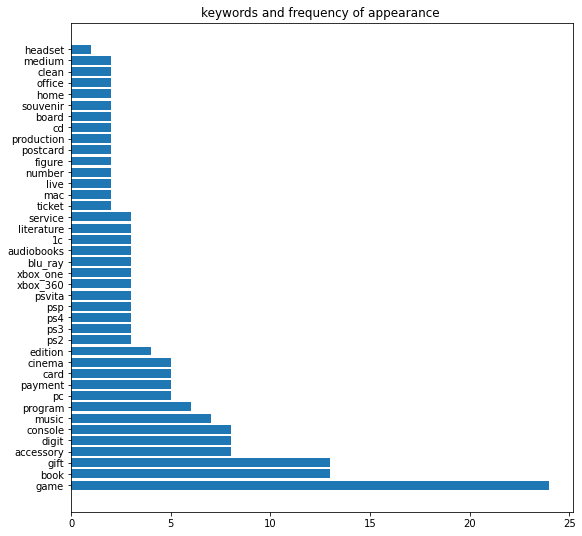

In [11]:
plot_top_words(clean_cat_name,40)

In [12]:
item_cat_num.shape

(84, 93)

C:\Users\Ivan\AppData\Local\Temp/ipykernel_7412/3849403723.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_df[sentence]=stemmed_sentence


tc 17
center 16
shoppe 15
moscow 13
mega 7
trk 5
trc 5
yakutsk 4
tk 4
central 3
mall 3
city 3
tyumen 3
ordzhonikidze 2
56 2
fran 2
voronezh 2
zhukovsky 2
ul 2
chkalova 2
kazan 2
century 2
rio 2
krasnoyarsk 2
budenovsky 2
pav 2
novgorod 2
novosibirsk 2
horizon 2
spb 2
samara 2
ufa 2
adygea 1
balashikha 1
october_kinomir 1
volzhsky 1
volga 1
vologda 1
marmalad 1
plekhanovskaya 1


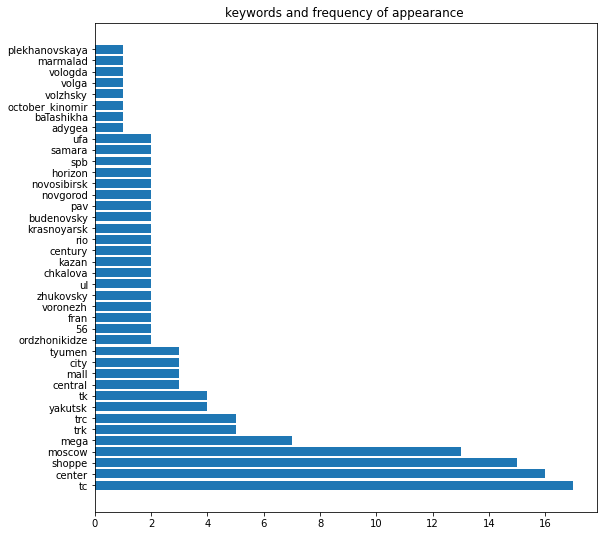

Count Vectorizer

   13  1c_online  39m  39m²  56  7i  a2  adygea  afi  altair  ...  volzhsky  \
0   0          0    0     0   1   0   0       0    0       0  ...         0   
1   0          0    0     0   0   0   0       0    0       0  ...         0   
2   0          0    0     0   0   0   0       1    0       0  ...         0   
3   0          0    0     0   0   0   0       0    0       0  ...         0   
4   0          0    0     0   0   0   0       0    0       0  ...         1   

   voronezh  voronež  warehouse  white  xl_3  xxi  yakutsk  yaroslavl  \
0         0        0          0      0     0    0        1          0   
1         0        0          0      0     0    0        1          0   
2         0        0          0      0     0    0        0          0   
3         0        0          0      0     0    0        0          0   
4         0        0          0      0     0    0        0          0   

   zhukovsky  
0          0  
1          0  
2          0  
3       

C:\Users\Ivan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [13]:
clean_shop_name=text_cleaning(shops.shop_name)
plot_top_words(clean_shop_name,40)
shop_num=text_tfidf_num(clean_shop_name)

Now that we have added numeric categorical features, as well as numeric shop name features,
we are going to incorporate into the item_categories and shops by their respective IDs.

In [14]:
shop_num.head(5)
#shops.merge(shop_num,how='left',on='shop_id')

,13,1c_online,39m,39m²,56,7i,a2,adygea,afi,altair,...,volzhsky,voronezh,voronež,warehouse,white,xl_3,xxi,yakutsk,yaroslavl,zhukovsky
0,0.0,0.0,0.0,0.0,0.515602,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.449958,0.0,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.481477,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.761716,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.554122,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [15]:
shop_num['shop_id']=shops['shop_id']
#shopss=shops.merge(shop_num,how='')

In [16]:
shopsnew=shop_num.merge(shops,how='left',on='shop_id')

In [17]:
shopsnew.head(3).T

,0,1,2
13,0.0,0.0,0.0
1c_online,0.0,0.0,0.0
39m,0.0,0.0,0.0
39m²,0.0,0.0,0.0
56,0.515602,0.0,0.0
...,...,...,...
yakutsk,0.449958,0.481477,0.0
yaroslavl,0.0,0.0,0.0
zhukovsky,0.0,0.0,0.0
shop_id,0,1,2


In [18]:
# since we already transformed 'shops' text to a new dataframe 'shopsnew', lets make a transformed dataframe for categories
item_categories.head(3).T

,0,1,2
item_category_name,pc headset headphone,accessory ps2,accessory ps3
item_category_id,0,1,2


In [19]:
item_cat_num.columns

Index(['1c', '3d', '4k', 'accessory', 'additional', 'album', 'android',
       'artbooks', 'attribute', 'audiobooks', 'bag', 'blu_ray', 'board',
       'book', 'business', 'card', 'cd', 'certificate', 'cinema', 'clean',
       'cognitive', 'collectible', 'collectivity', 'comic', 'compact',
       'computer', 'console', 'corporate', 'delivery', 'development', 'digit',
       'dvd', 'edition', 'educational', 'element', 'encyclopedia',
       'enterprise', 'fiction', 'figure', 'film', 'gadget', 'game', 'gift',
       'good', 'guidebook', 'headphone', 'headset', 'hitch', 'home',
       'literature', 'live', 'local', 'mac', 'manga', 'material', 'medium',
       'methodological', 'mouse', 'mp3', 'music', 'number', 'office',
       'payment', 'pc', 'piece', 'postcard', 'power', 'production', 'program',
       'ps2', 'ps3', 'ps4', 'psn', 'psp', 'psvita', 'robot', 'rug', 'service',
       'soft', 'souvenir', 'spire', 'sport', 'standard', 'sticker', 'ticket',
       'toy', 'traine', 'video', 'vi

In [20]:
item_cat_num['item_category_id']=item_categories.item_category_id
item_categoriesnew=pd.merge(item_categories,item_cat_num,on='item_category_id')

In [21]:
item_categoriesnew.head(3).T
item_categoriesnew.shape
shopsnew.shape

(60, 120)

### 2.3 Extracting numeric features and cleaning <a name="Tag2.3"></a> 
most numeric features lies within sales, so let's describe it and clean it

In [22]:
print(sales_train.head(5).T)
sales_train.describe()

                                  0                    1                    2  \
date            2013-01-02 00:00:00  2013-01-03 00:00:00  2013-01-05 00:00:00   
date_block_num                    0                    0                    0   
shop_id                          59                   25                   25   
item_id                       22154                 2552                 2552   
item_price                    999.0                899.0                899.0   
item_cnt_day                    1.0                  1.0                 -1.0   

                                  3                    4  
date            2013-01-06 00:00:00  2013-01-15 00:00:00  
date_block_num                    0                    0  
shop_id                          25                   25  
item_id                        2554                 2555  
item_price                  1709.05               1099.0  
item_cnt_day                    1.0                  1.0  


,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


In [23]:
# Impute outliers, price cannot go negative
sales_train[sales_train.item_price<0].head(5)
priceimpute=sales_train[sales_train.item_price>0].median()
print(priceimpute)

date_block_num      14.0
shop_id             31.0
item_id           9343.0
item_price         399.0
item_cnt_day         1.0
dtype: float64


C:\Users\Ivan\AppData\Local\Temp/ipykernel_7412/1074712210.py:3: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  priceimpute=sales_train[sales_train.item_price>0].median()


<AxesSubplot:title={'center':'item_price in raw training dataset'}, xlabel='item_price'>

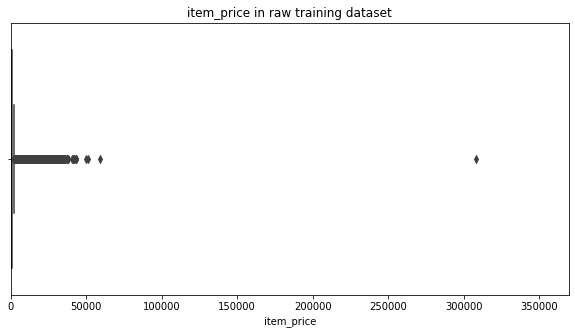

In [24]:
plt.figure(figsize=(10,5))
plt.xlim(sales_train.item_price.min(), sales_train.item_price.max()*1.2)
plt.title ('item_price in raw training dataset')
sns.boxplot(x=sales_train.item_price)

<AxesSubplot:title={'center':'item_price in raw training dataset (after imputing)'}, xlabel='item_price'>

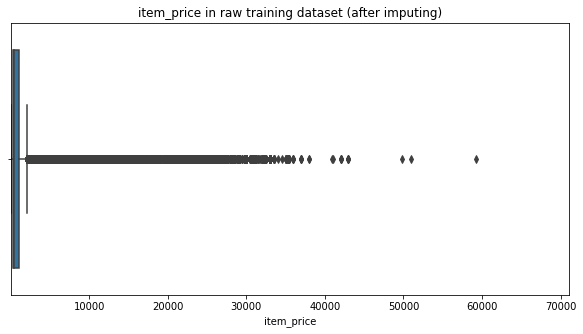

In [25]:
sales_train.loc[sales_train.item_price>300000,'item_price']=priceimpute.item_price
sales_train.loc[sales_train.item_price<0,'item_price']=priceimpute.item_price
# We also see that items priced 300K is an outlier, impute it with median as well
# impute the data point which has outlier pricing
plt.figure(figsize=(10,5))
plt.xlim(sales_train.item_price.min(), sales_train.item_price.max()*1.2)
plt.title ('item_price in raw training dataset (after imputing)')
sns.boxplot(x=sales_train.item_price)

### 3. EDA and CV dataset preparation <a name="Tag3"></a> 
Next, we will need to calculate the accumulated monthly sale and add it to sales_train
In order to do that, we must account for all possible unique shop_id and item_id ,construct a big set
and group by these features. 
we will combine the test dataset as well 


In [26]:
# For every month we create a grid from all shops/items combinations from that month
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = []
for block_num in sales_train['date_block_num'].unique():
    cur_shops = sales_train.loc[sales_train['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = sales_train.loc[sales_train['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

grid = pd.DataFrame(np.vstack(grid), columns = index_cols, dtype=np.int32)

In [27]:
test_block = 34
test['date_block_num'] = test_block
test = test.drop(columns=['ID'])
grid = pd.concat([grid, test])

In [28]:
# Groupby data to get shop-item-month aggregates
gb = sales_train.groupby(index_cols, as_index=False)['item_cnt_day'].sum()
gb = gb.rename(columns={'item_cnt_day': 'target'})
all_data = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)

# Same as above but with shop-month aggregates
gb = sales_train.groupby(['shop_id', 'date_block_num'], as_index=False)['item_cnt_day'].sum()
gb = gb.rename(columns={'item_cnt_day': 'target_shop'})
all_data = pd.merge(all_data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)

# Same as above but with item-month aggregates
gb = sales_train.groupby(['item_id', 'date_block_num'], as_index=False)['item_cnt_day'].sum()
gb = gb.rename(columns={'item_cnt_day': 'target_item'})
all_data = pd.merge(all_data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)

# lastly, add back the item_price column
all_data= pd.merge(all_data, sales_train, how='left', left_on=['item_id', 'shop_id','date_block_num'],right_on=['item_id', 'shop_id','date_block_num']).fillna(0)

# Downcast dtypes from 64 to 32 bit to save memory
all_data = downcast_dtypes(all_data)
del grid, gb 
gc.collect()

0

In [29]:
all_data.pop('date')
all_data.pop('item_cnt_day')
# we don't need these anymore since we already have the month info and item_cnt_month(target)
all_data.info()
# garbage collection code to handle memory issues further- probably not needed. 
# Referred to Abhishekmamidi123 at github

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12454775 entries, 0 to 12454774
Data columns (total 7 columns):
 #   Column          Dtype  
---  ------          -----  
 0   shop_id         int16  
 1   item_id         int16  
 2   date_block_num  int16  
 3   target          float32
 4   target_shop     float32
 5   target_item     float32
 6   item_price      float32
dtypes: float32(4), int16(3)
memory usage: 356.3 MB


We can see that some feature names are the same, so let's merge all of the raw data in a single file 
Be careful for this part : for training data set, we want to be exhaustive of all possible values of features, so we do outer join merge
for test dataset, we only want to account for item_categories that agrees with that is provided in the competition (item_id and shop_id)

In [30]:
all_data.shape

(12454775, 7)

In [31]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12454775 entries, 0 to 12454774
Data columns (total 7 columns):
 #   Column          Dtype  
---  ------          -----  
 0   shop_id         int16  
 1   item_id         int16  
 2   date_block_num  int16  
 3   target          float32
 4   target_shop     float32
 5   target_item     float32
 6   item_price      float32
dtypes: float32(4), int16(3)
memory usage: 356.3 MB


We get a merged train-test dataset with all numeric features insofar.
Since we still have extracted text-to-number features saved in shopsnew with foreign key 'shop_id', and item_categoriesnew with foreign key 'item_category_id', we can merge them into the combined set

However, we already know that we have generated text-derived numeric features and they have lots of columns.
shopsnew has 100+ features and item_categories has 90+ features. They are all very sparse. Merging sales_train with 11m rows with these will consume too much memory. We need to compress these sparse features. Since words freq are not negative, we can do NMF transform

In [32]:
allitems=items.merge(item_categoriesnew,on='item_category_id')
allshops=shops.merge(shopsnew,on='shop_id')

In [33]:
shopsnew.head(5).T

,0,1,2,3,4
13,0.0,0.0,0.0,0.0,0.0
1c_online,0.0,0.0,0.0,0.0,0.0
39m,0.0,0.0,0.0,0.0,0.0
39m²,0.0,0.0,0.0,0.0,0.0
56,0.515602,0.0,0.0,0.0,0.0
...,...,...,...,...,...
yakutsk,0.449958,0.481477,0.0,0.0,0.0
yaroslavl,0.0,0.0,0.0,0.0,0.0
zhukovsky,0.0,0.0,0.0,0.0,0.0
shop_id,0,1,2,3,4


In [34]:
# list top 10 shop name categories - see 'top words' figure I plotted. Most frequenly used words>3 are here
shopsnew.pop('shop_name')
modelnmf=NMF(n_components=10)
modelnmf.fit(shopsnew)
nmf_shopname=modelnmf.transform(shopsnew)

C:\Users\Ivan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
C:\Users\Ivan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [35]:
shopsnmf=pd.DataFrame(nmf_shopname)
shopsnmf['shop_id']=shops.shop_id

In [36]:
shopsnmf.columns=['shopcat0','shopcat1','shopcat2','shopcat3','shopcat4','shopcat5','shopcat6','shopcat7',
'shopcat8','shopcat9','shop_id']

In [37]:
shopsnmf.head(5)

,shopcat0,shopcat1,shopcat2,shopcat3,shopcat4,shopcat5,shopcat6,shopcat7,shopcat8,shopcat9,shop_id
0,0.000000,0.000000,0.000000,0.000000,6.568640e-01,0.000000,0.0,0.000000,0.000000e+00,0.000000,0
1,0.060618,0.203924,0.025949,0.000000,4.403157e-01,0.000000,0.0,0.000000,0.000000e+00,0.000000,1
2,0.122036,0.000000,0.009682,0.000000,0.000000e+00,0.000000,0.0,0.369699,6.679130e-07,0.000000,2
3,0.183649,0.000000,0.000000,0.000000,9.020426e-09,0.000000,0.0,0.000000,0.000000e+00,0.365548,3
4,0.244698,0.225871,0.000000,0.009341,0.000000e+00,0.121658,0.0,0.000000,0.000000e+00,0.000000,4


In [38]:
all_data=all_data.merge(shopsnmf,on='shop_id')
all_data.isnull().values.any()
# make sure no nans

False

In [39]:
# similarlly we do nmf transform to the item_name text-to-numeric features
item_categoriesnew.pop('item_category_name')
modelnmf=NMF(n_components=10)
modelnmf.fit(item_categoriesnew)
nmf_catname=modelnmf.transform(item_categoriesnew)

C:\Users\Ivan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
C:\Users\Ivan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [40]:
print(nmf_catname.shape)
print(items.columns)


(84, 10)
Index(['item_name', 'item_id', 'item_category_id'], dtype='object')


In [41]:
itemcatnmf=pd.DataFrame(nmf_catname)
itemcatnmf['item_category_id']=item_categories.item_category_id
print(itemcatnmf.head(5))

          0    1    2         3    4    5        6             7    8    9  \
0  0.000000  0.0  0.0  0.000000  0.0  0.0  0.31242  0.000000e+00  0.0  0.0   
1  0.047119  0.0  0.0  0.463194  0.0  0.0  0.00000  2.433042e-07  0.0  0.0   
2  0.094764  0.0  0.0  0.463182  0.0  0.0  0.00000  0.000000e+00  0.0  0.0   
3  0.142409  0.0  0.0  0.463171  0.0  0.0  0.00000  0.000000e+00  0.0  0.0   
4  0.190054  0.0  0.0  0.463160  0.0  0.0  0.00000  0.000000e+00  0.0  0.0   

   item_category_id  
0                 0  
1                 1  
2                 2  
3                 3  
4                 4  


In [42]:
itemcatnmf.columns=['itemcat0','itemcat1','itemcat2','itemcat3','itemcat4','itemcat5','itemcat6','itemcat7','itemcat8','itemcat9','item_category_id']
itemcatnmf.shape

(84, 11)

In [43]:
all_items=items.merge(itemcatnmf,on='item_category_id')
all_items.pop('item_name')
all_items.head(5)

,item_id,item_category_id,itemcat0,itemcat1,itemcat2,itemcat3,itemcat4,itemcat5,itemcat6,itemcat7,itemcat8,itemcat9
0,0,40,1.903922,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.511251,0.0
1,2,40,1.903922,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.511251,0.0
2,3,40,1.903922,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.511251,0.0
3,4,40,1.903922,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.511251,0.0
4,5,40,1.903922,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.511251,0.0


In [44]:
all_data=all_data.merge(all_items,on='item_id')
all_data.isnull().values.any()
# check if any data is nan

False

Success ! Now we have a combined dataset with all possible shop_id, item_id and date_block_num. 
We can look at the header and describe it

In [45]:
all_data=downcast_dtypes(all_data)
all_data.info()
# It takes about 1.3G for thhe entire dataset sofar . Pure numeric, all text features are converted. 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12454775 entries, 0 to 12454774
Data columns (total 28 columns):
 #   Column            Dtype  
---  ------            -----  
 0   shop_id           int16  
 1   item_id           int16  
 2   date_block_num    int16  
 3   target            float32
 4   target_shop       float32
 5   target_item       float32
 6   item_price        float32
 7   shopcat0          float32
 8   shopcat1          float32
 9   shopcat2          float32
 10  shopcat3          float32
 11  shopcat4          float32
 12  shopcat5          float32
 13  shopcat6          float32
 14  shopcat7          float32
 15  shopcat8          float32
 16  shopcat9          float32
 17  item_category_id  int16  
 18  itemcat0          float32
 19  itemcat1          float32
 20  itemcat2          float32
 21  itemcat3          float32
 22  itemcat4          float32
 23  itemcat5          float32
 24  itemcat6          float32
 25  itemcat7          float32
 26  itemcat8    

### 3.1 Visualize general trends <a name="Tag3.1"></a> 
Let's visualize the time series trend of sales first

C:\Users\Ivan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Number of items sold in each month, note that month 34 is to be predicted')

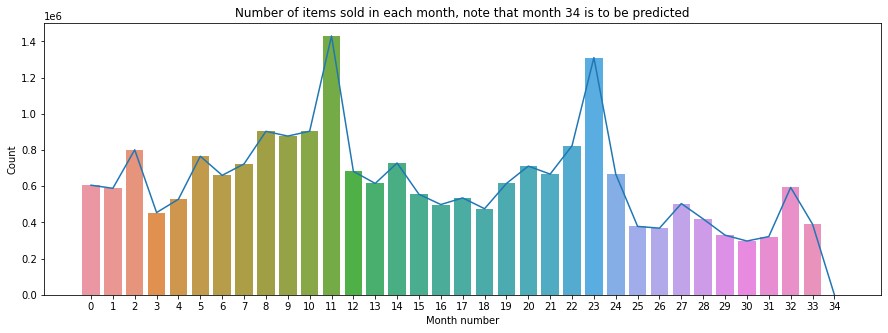

In [46]:
item_cnt_month = all_data.groupby('date_block_num')['target'].sum()
plt.figure(figsize=(15,5))
sns.barplot(item_cnt_month.index, item_cnt_month.values)
plt.plot(item_cnt_month.index, item_cnt_month.values)
plt.xlabel("Month number")
plt.ylabel("Count")
plt.title("Number of items sold in each month, note that month 34 is to be predicted")

C:\Users\Ivan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Popular shops')

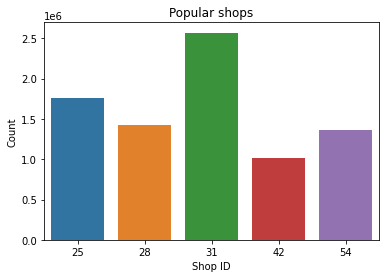

In [47]:
# popular shop numbers
popular_shops = all_data.groupby('shop_id')['target'].sum()
popular_shops = popular_shops.sort_values(ascending=False)[:5]
sns.barplot(popular_shops.index, popular_shops.values)
plt.xlabel("Shop ID")
plt.ylabel("Count")
plt.title("Popular shops")

In [48]:
all_data.columns

Index(['shop_id', 'item_id', 'date_block_num', 'target', 'target_shop',
       'target_item', 'item_price', 'shopcat0', 'shopcat1', 'shopcat2',
       'shopcat3', 'shopcat4', 'shopcat5', 'shopcat6', 'shopcat7', 'shopcat8',
       'shopcat9', 'item_category_id', 'itemcat0', 'itemcat1', 'itemcat2',
       'itemcat3', 'itemcat4', 'itemcat5', 'itemcat6', 'itemcat7', 'itemcat8',
       'itemcat9'],
      dtype='object')

In [49]:
all_data.shape

(12454775, 28)

(0.0, 100000.0)

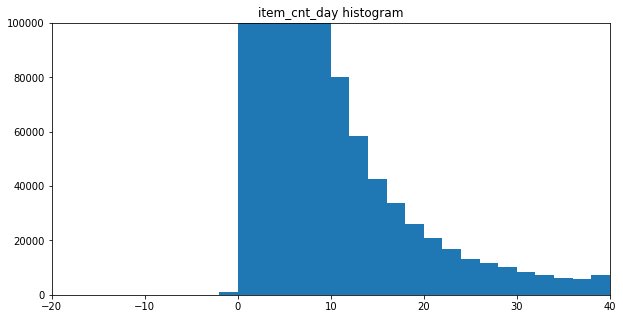

In [50]:
# Lastly, we want to check the histogram of the target. The competition specifies that final output be clipped to 
# [0 20]. Let's see if it  makes sense or not
plt.figure(figsize=(10,5))
plt.title ('item_cnt_day histogram')
plt.hist(x=all_data.target,bins=np.linspace(-20,40,31))  
# the bins are from -20:2:40 
plt.xlim(-20,40)
plt.ylim(0,1e5)

### 3.2 Data Leakage <a name="Tag3.2"></a> 
Let's examine the pre-combination training and test data features, focusing on the indexing features
shops_id and item_id

In [51]:
shop_idstrain = (sales_train['shop_id'].unique())  
item_idstrain = (sales_train['item_id'].unique())
shop_idstest  = (test['shop_id'].unique())
item_idstest  = (test['item_id'].unique())
# these above are arrays
# we know that rain dataset has 60 unique shop and 21807 unique items while test dataset has 42 unique shops and 5100 unique items
# To build a training dataset that includes all possible shopId and itemID, we need to use outer join instead of left or right join
# Because it is possible that test dataset has shopID and itemID that is not  present in the training set

all1=[]
all2=[]
all1          = pd.merge(pd.DataFrame(shop_idstrain),pd.DataFrame(shop_idstest),how='outer')
all2          = pd.merge(pd.DataFrame(item_idstrain),pd.DataFrame(item_idstest),how='outer')
shop_idsall   =all1.values
item_idsall   =all2.values
# these are also arrays


print('Unique shops in training, test, and joined sets are')
print(sales_train['shop_id'].nunique())
print(test['shop_id'].nunique())
print(shop_idsall.shape)
print()
print('Unique item in training, test and joined sets are')
print(sales_train['item_id'].nunique())
print(test['item_id'].nunique())
print(item_idsall.shape)


Unique shops in training, test, and joined sets are
60
42
(60, 1)

Unique item in training, test and joined sets are
21807
5100
(22170, 1)


Because 21807 is less than 22170, we know that some items are only appearing in the test dataset.
### 3.3 Construct training set <a name="Tag3.3"></a> 

In [52]:
all_data.head(5)

,shop_id,item_id,date_block_num,target,target_shop,target_item,item_price,shopcat0,shopcat1,shopcat2,...,itemcat0,itemcat1,itemcat2,itemcat3,itemcat4,itemcat5,itemcat6,itemcat7,itemcat8,itemcat9
0,59,22154,0,1.0,2017.0,18.0,999.0,3.623603,0.23524,0.0,...,1.761517,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.366313,0.0
1,59,22154,1,0.0,1897.0,6.0,0.0,3.623603,0.23524,0.0,...,1.761517,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.366313,0.0
2,59,22154,2,0.0,2028.0,2.0,0.0,3.623603,0.23524,0.0,...,1.761517,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.366313,0.0
3,59,22154,3,0.0,1388.0,3.0,0.0,3.623603,0.23524,0.0,...,1.761517,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.366313,0.0
4,59,22154,7,0.0,2048.0,2.0,0.0,3.623603,0.23524,0.0,...,1.761517,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.366313,0.0


Here we formulate train-split strategies: 
First, we understand that there are still shop_id, item_id,date_block_num, that are certainly categorical features and are discrete. We would need to perform label encoding or mean encoding to better separate them. It has to be done after the split
Secondly, we can still do more feature engineering on these categorical features. We can conver date_block_num to month and year (1 feature to 3 features)
Thirdly, we can add time-lagging features for target( sales of item_cnt_month), add previous 1,2,3,12 month target as predictive features
Lastly, train_test split should be performed with such that validation set right precedes date_block_num 34 to account time series

In [53]:
# More feature engineering - add month and year data
all_data['year'] = all_data['date_block_num'].apply(lambda x: ((x//12) + 2013))
all_data['month']= all_data['date_block_num'].apply(lambda x: (x % 12)+ 1 )

In [54]:
all_data.columns

Index(['shop_id', 'item_id', 'date_block_num', 'target', 'target_shop',
       'target_item', 'item_price', 'shopcat0', 'shopcat1', 'shopcat2',
       'shopcat3', 'shopcat4', 'shopcat5', 'shopcat6', 'shopcat7', 'shopcat8',
       'shopcat9', 'item_category_id', 'itemcat0', 'itemcat1', 'itemcat2',
       'itemcat3', 'itemcat4', 'itemcat5', 'itemcat6', 'itemcat7', 'itemcat8',
       'itemcat9', 'year', 'month'],
      dtype='object')

### 3.4 Add numeric lag features <a name="Tag3.4"></a> 
As we discussed, here we add previous month sale count (target) for the past 1,3,12 months, as well as for shop-specific target, item- specific target.

In [55]:
lag_list = [1, 3,12]
from tqdm import tqdm
# create target lag (item_cnt_month) for 1,3,12 months
for lag in tqdm(lag_list):
    ft_name = ('target_lag%s' % lag)
    all_data[ft_name] = all_data.sort_values('date_block_num').groupby(['shop_id', 'item_category_id', 'item_id'])['target'].shift(lag)
    all_data[ft_name].fillna(0, inplace=True)

100%|██████████| 3/3 [00:24<00:00,  8.01s/it]


In [56]:
# create target_shop and target_item lag features for 1,3,12 months
for lag in tqdm(lag_list):
    ft_name = ('target_shoplag%s' % lag)
    all_data[ft_name] = all_data.sort_values('date_block_num').groupby(['shop_id', 'item_category_id', 'item_id'])['target_shop'].shift(lag)
    all_data[ft_name].fillna(0, inplace=True)

100%|██████████| 3/3 [00:24<00:00,  8.32s/it]


In [57]:
for lag in tqdm(lag_list):
    ft_name = ('target_itemlag%s' % lag)
    all_data[ft_name] = all_data.sort_values('date_block_num').groupby(['shop_id', 'item_category_id', 'item_id'])['target_item'].shift(lag)
    all_data[ft_name].fillna(0, inplace=True)

100%|██████████| 3/3 [00:26<00:00,  8.74s/it]


Now let's plot some trends of the data after the basic cleaning
We want to see the sales trend with respect to different month , find out the popular items and shops

### Section 3 EDA and feature extractions
first, let's check the leakage between train and test set

In [58]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12454775 entries, 0 to 12454774
Data columns (total 39 columns):
 #   Column            Dtype  
---  ------            -----  
 0   shop_id           int16  
 1   item_id           int16  
 2   date_block_num    int16  
 3   target            float32
 4   target_shop       float32
 5   target_item       float32
 6   item_price        float32
 7   shopcat0          float32
 8   shopcat1          float32
 9   shopcat2          float32
 10  shopcat3          float32
 11  shopcat4          float32
 12  shopcat5          float32
 13  shopcat6          float32
 14  shopcat7          float32
 15  shopcat8          float32
 16  shopcat9          float32
 17  item_category_id  int16  
 18  itemcat0          float32
 19  itemcat1          float32
 20  itemcat2          float32
 21  itemcat3          float32
 22  itemcat4          float32
 23  itemcat5          float32
 24  itemcat6          float32
 25  itemcat7          float32
 26  itemcat8    

### 3.5 Mean encoding categorical features  <a name="Tag3.5"></a> 
we need to mean encode categorical features before finalize the datasets
since we had done a shift of 12 month maximum, we can't use the first 12 months of data 

In [59]:
# Let's discard the first 12 months before building models and use the rest of them
# also enforce that each item corresponds to unique item_category_id. this will shrink CV combined dataset to 7million records. 
all_data = all_data[all_data['date_block_num'] >= 12]
print(all_data.shape)
#item_category_mapping = items[['item_id', 'item_category_id']].drop_duplicates()
#all_data = pd.merge(all_data, item_category_mapping, how='left', on='item_id')
# THIS ENSURES THAT category gets carried over to the all-data dataset  , both training and test
all_data = downcast_dtypes(all_data)
gc.collect()

(7386181, 39)


4461

In [60]:
X_train     =all_data.query('date_block_num>12 and date_block_num<28').copy()
X_validation=all_data.query('date_block_num>=28 and date_block_num<34').copy()
X_test      =all_data.query('date_block_num==34').copy()
all_train   =all_data.query('date_block_num<34').copy()

Therefore it is clear to us that training dataset does not include some of the test dataset item_id. We need expand training dataset to include all 
possible item_id
Let's start with a null dataframe and build it

In [61]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5288120 entries, 590 to 12164900
Data columns (total 39 columns):
 #   Column            Dtype  
---  ------            -----  
 0   shop_id           int16  
 1   item_id           int16  
 2   date_block_num    int16  
 3   target            float32
 4   target_shop       float32
 5   target_item       float32
 6   item_price        float32
 7   shopcat0          float32
 8   shopcat1          float32
 9   shopcat2          float32
 10  shopcat3          float32
 11  shopcat4          float32
 12  shopcat5          float32
 13  shopcat6          float32
 14  shopcat7          float32
 15  shopcat8          float32
 16  shopcat9          float32
 17  item_category_id  int16  
 18  itemcat0          float32
 19  itemcat1          float32
 20  itemcat2          float32
 21  itemcat3          float32
 22  itemcat4          float32
 23  itemcat5          float32
 24  itemcat6          float32
 25  itemcat7          float32
 26  itemcat8   

In [62]:
y_train     = X_train['target'].values
y_validation= X_validation['target'].values
y_test      = X_test['target'].values

In [63]:
# Mean encoding here
# We have 5 categorical features: year, month, shop_id, item_id and item_category_id
# We should use the combination of train/validation set target mean to encode.

means_shop_id =all_train.groupby('shop_id').target.mean()
means_item_id =all_train.groupby('item_id').target.mean()
means_category=all_train.groupby('item_category_id').target.mean()
means_year    =all_train.groupby('year').target.mean()
means_month   =all_train.groupby('month').target.mean()

In [64]:
X_train['shop_id'+'_mean_target']=X_train['shop_id'].map(means_shop_id)
X_validation['shop_id'+'_mean_target']=X_validation['shop_id'].map(means_shop_id)
all_train['shop_id'+'_mean_target']=all_train['shop_id'].map(means_shop_id)
X_test['shop_id'+'_mean_target']=X_test['shop_id'].map(means_shop_id)

X_train['item_id'+'_mean_target']=X_train['item_id'].map(means_item_id)
X_validation['item_id'+'_mean_target']=X_validation['item_id'].map(means_item_id)
all_train['item_id'+'_mean_target']=all_train['item_id'].map(means_item_id)
X_test['item_id'+'_mean_target']=X_test['item_id'].map(means_item_id)

X_train['category'+'_mean_target']=X_train['item_category_id'].map(means_category)
X_validation['category'+'_mean_target']=X_validation['item_category_id'].map(means_category)
all_train['category'+'_mean_target']=all_train['item_category_id'].map(means_category)
X_test['category'+'_mean_target']=X_test['item_category_id'].map(means_category)

X_train['year'+'_mean_target']=X_train['year'].map(means_year)
X_validation['year'+'_mean_target']=X_validation['year'].map(means_year)
all_train['year'+'_mean_target']=all_train['year'].map(means_year)
X_test['year'+'_mean_target']=X_test['year'].map(means_year)

X_train['month'+'_mean_target']=X_train['month'].map(means_month)
X_validation['month'+'_mean_target']=X_validation['month'].map(means_month)
all_train['month'+'_mean_target']=all_train['month'].map(means_month)
X_test['month'+'_mean_target']=X_test['month'].map(means_month)

X_test.fillna(X_test.mean(), inplace=True)

In [66]:
print(X_train.shape)
print(y_train.shape)
print(X_validation.shape)
print(y_validation.shape)
print(X_test.shape)
print(y_test.shape)

(5288120, 44)
(5288120,)
(1490486, 44)
(1490486,)
(214200, 44)
(214200,)


In [67]:
X_train.columns

Index(['shop_id', 'item_id', 'date_block_num', 'target', 'target_shop',
       'target_item', 'item_price', 'shopcat0', 'shopcat1', 'shopcat2',
       'shopcat3', 'shopcat4', 'shopcat5', 'shopcat6', 'shopcat7', 'shopcat8',
       'shopcat9', 'item_category_id', 'itemcat0', 'itemcat1', 'itemcat2',
       'itemcat3', 'itemcat4', 'itemcat5', 'itemcat6', 'itemcat7', 'itemcat8',
       'itemcat9', 'year', 'month', 'target_lag1', 'target_lag3',
       'target_lag12', 'target_shoplag1', 'target_shoplag3',
       'target_shoplag12', 'target_itemlag1', 'target_itemlag3',
       'target_itemlag12', 'shop_id_mean_target', 'item_id_mean_target',
       'category_mean_target', 'year_mean_target', 'month_mean_target'],
      dtype='object')

In [139]:
# Lastly we specify the clipping of target
target_range = [0, 20]
target_range

y_train=y_train.clip(*target_range)
y_validation=y_validation.clip(*target_range)
y_test=y_test.clip(*target_range)

In [124]:
X_train.pop('target')
X_validation.pop('target')
X_test.pop('target')

12          0.0
29          0.0
42          0.0
59          0.0
72          0.0
           ... 
12454770    0.0
12454771    0.0
12454772    0.0
12454773    0.0
12454774    0.0
Name: target, Length: 214200, dtype: float32

In [127]:
X_train.pop('target_shop')
X_train.pop('target_item')
X_validation.pop('target_shop')
X_validation.pop('target_item')
X_test.pop('target_shop')
X_test.pop('target_item')
# we don't need these any more as target should not be in the prediction process

12          0.0
29          0.0
42          0.0
59          0.0
72          0.0
           ... 
12454770    0.0
12454771    0.0
12454772    0.0
12454773    0.0
12454774    0.0
Name: target_item, Length: 214200, dtype: float32

### 4 Modeling  <a name="Tag4"></a> 

&nbsp;&nbsp;&nbsp;[4.1 Model selection, train and validation strategies](#Tag4.1)   
In this competition we first opt the fastest models: linear regression and lightgbm. lightgbm is chosen over xgboost for speed
we would also explore advanced catboost as mentioned in coursera course. Finally we will evaluate the ensembling bagging. 
Boosting is also evaluated
Here knn , other tree methods were not used due to training speed issues. You could also do MLP, LSTM ,etc neural modeling.

&nbsp;&nbsp;&nbsp;[4.2 LightGBM](#Tag4.2)  


In [147]:
#  Use only part of features on XGBoost. - alternatively , use X_train.columns to include all features
lgb_features = ['target_lag1','target_lag3','target_lag12','year_mean_target','month_mean_target',
'target_shoplag1','target_shoplag3','target_shoplag12',
'target_itemlag1','target_itemlag3','target_itemlag12',
'shopcat0','shopcat1','shopcat2',
'itemcat0','itemcat1','itemcat2',
'shop_id','item_id']
#lgb_features=X_train.columns
lgb_train = X_train[lgb_features]
lgb_validation=X_validation[lgb_features]
lgb_test= X_test[lgb_features]

In [148]:
lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':1, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.03, 
               'objective': 'mse', 
               'bagging_seed': 2**7,
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':0 
              }

#model = lgb.train(lgb_params, lgb.Dataset(X_train, label=y_train), 100)
lgb_model = lgb.train(lgb_params, lgb.Dataset(lgb_train, label=y_train), 100)

Y_train_lgb=lgb_model.predict(lgb_train).clip(*target_range)
Y_validation_lgb=lgb_model.predict(lgb_validation).clip(*target_range)
Y_test_lgb=lgb_model.predict(lgb_test).clip(*target_range)
print('Training RMSE',np.sqrt(mean_squared_error(y_train, Y_train_lgb)))
print('Validation RMSE',np.sqrt(mean_squared_error(y_validation, Y_validation_lgb)))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.404849 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training RMSE 0.9357765117735513
Validation RMSE 0.9205067908103267


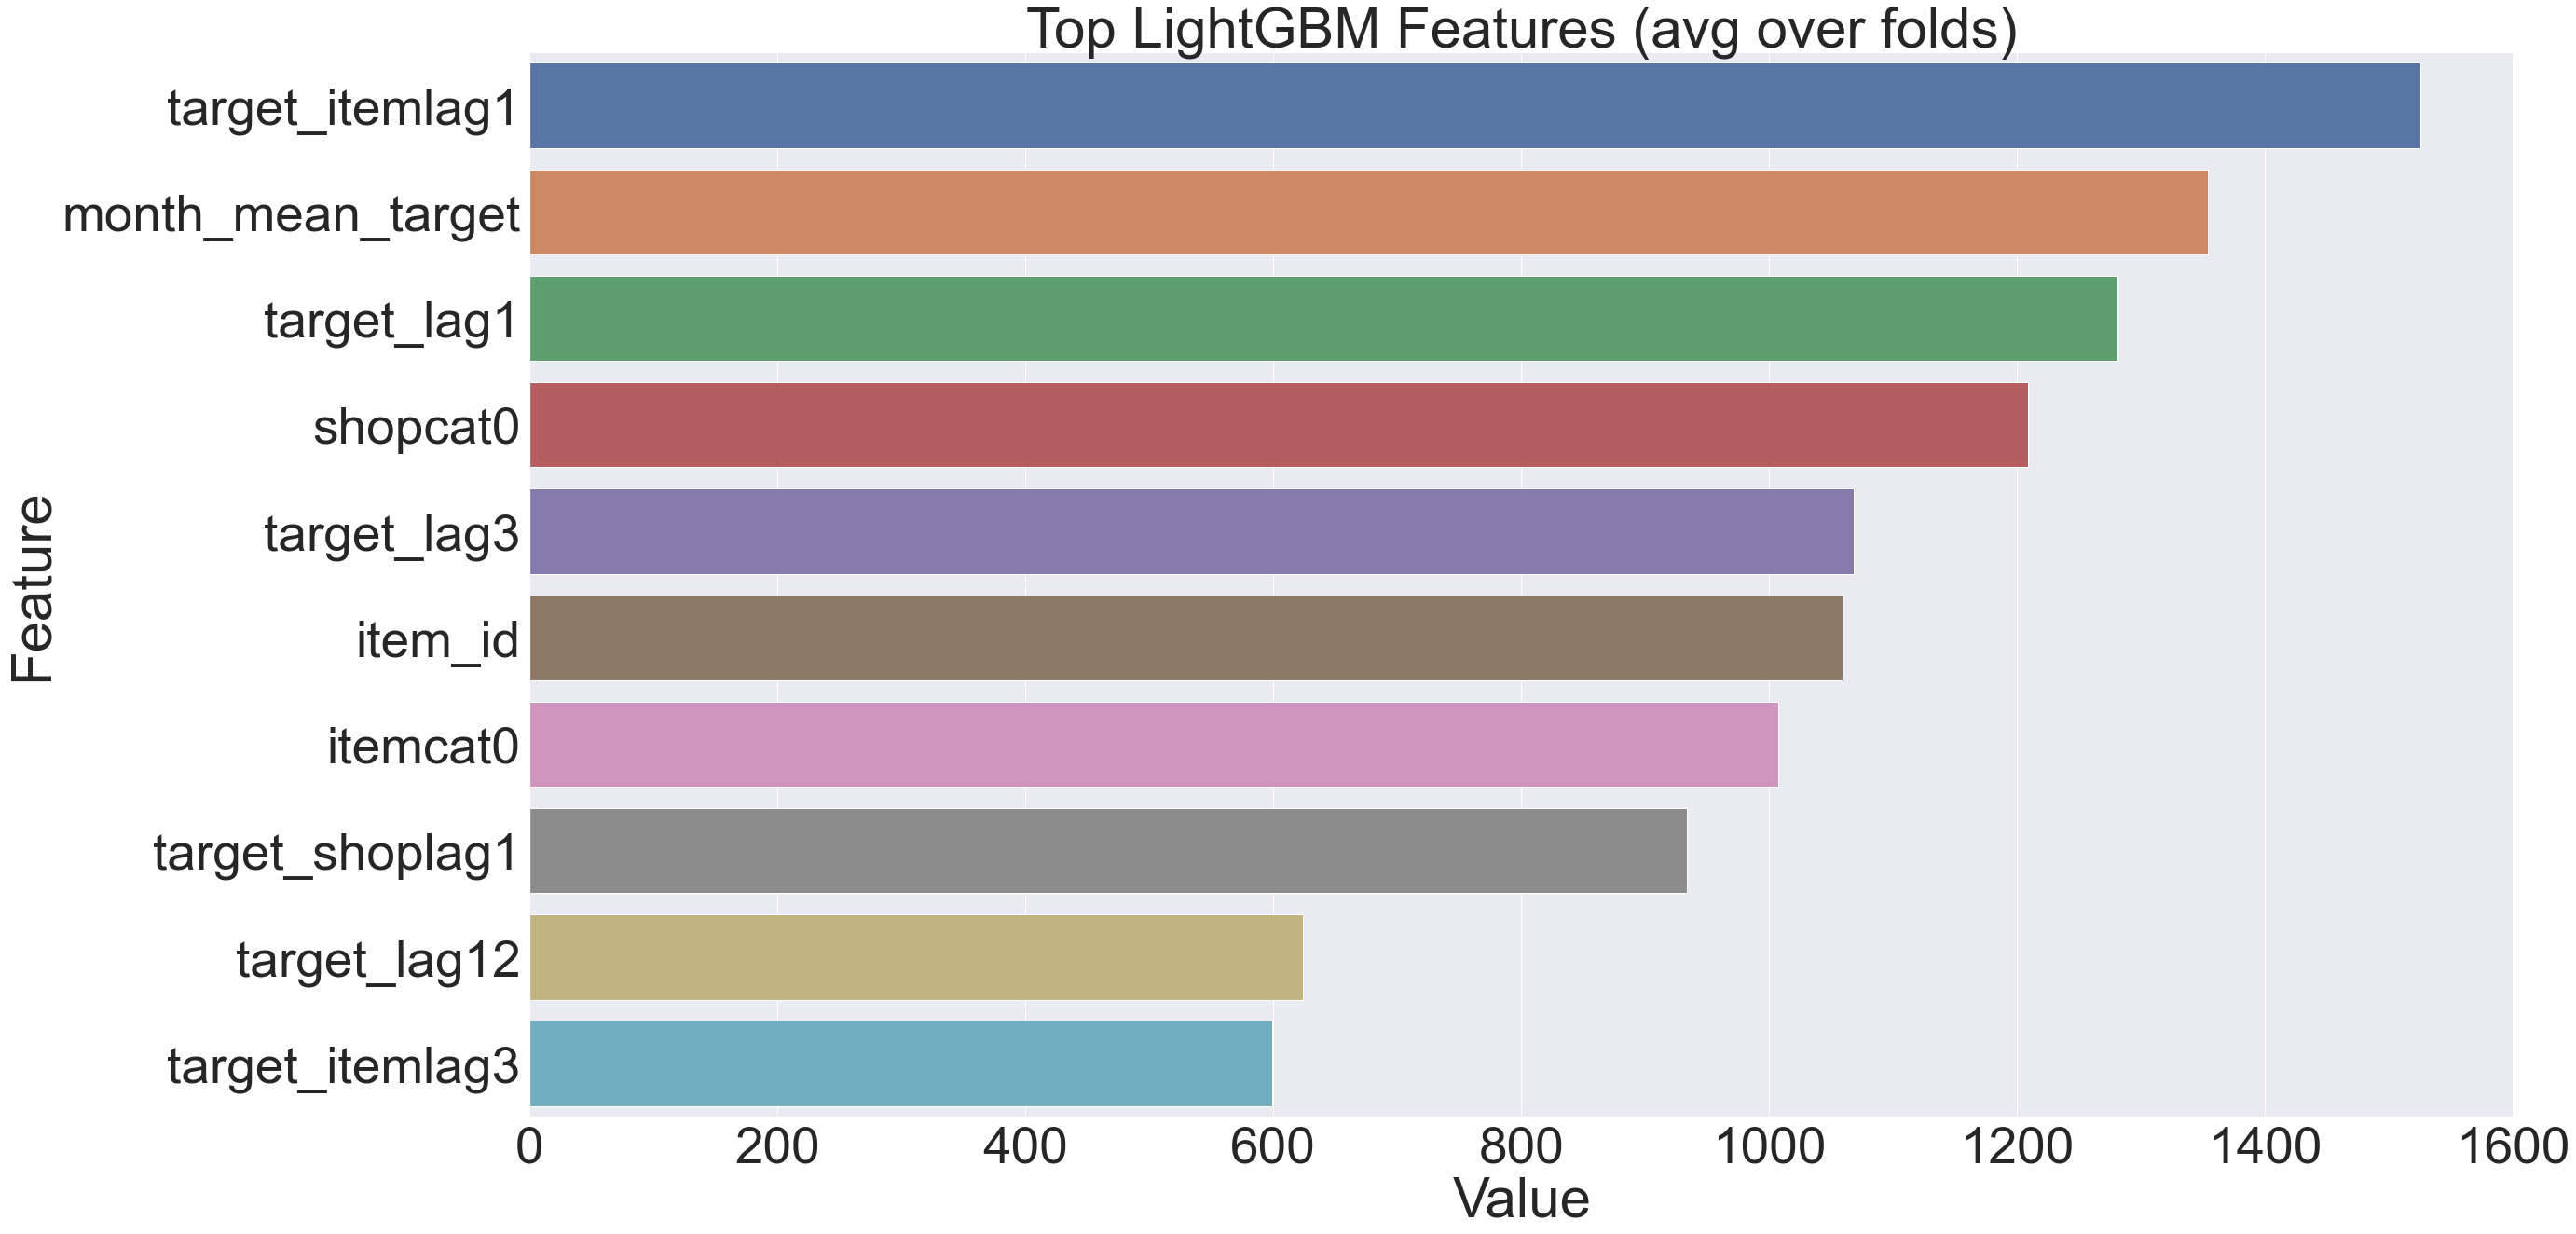

In [163]:
# Let's look at the feature importance ranks
# cited from stackoverflow  https://stackoverflow.com/questions/53413701/feature-importance-using-lightgbm
def plotImp(lgb_model, lgb_test, num = 10, fig_size = (40, 20)):
    feature_imp = pd.DataFrame({'Value':lgb_model.feature_importance(),'Feature':lgb_test.columns})
    plt.figure(figsize=fig_size)
    sns.set(font_scale = 5)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('Top LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances-01.png')
    plt.show()
    return (feature_imp.sort_values(by="Value",ascending=False)[0:num])
top10=plotImp(lgb_model, lgb_test, 10, fig_size = (40, 20))

In [170]:
top10
top10.Feature[0]
lr_features=top10.Feature
print(lr_features)
# this shows the importance over - folds 

8       target_itemlag1
4     month_mean_target
0           target_lag1
11             shopcat0
1           target_lag3
18              item_id
14             itemcat0
5       target_shoplag1
2          target_lag12
9       target_itemlag3
Name: Feature, dtype: object


&nbsp;&nbsp;&nbsp;[4.3 Linear model](#Tag4.3)
we will need to standardize some of them. 
Take a quick look at the text dataset features- item_id , year, target,target_shoplags are well 

In [171]:
# Use only some top features found in the lightgbm- it may be biased
# lr_features = ['target_lag1','target_lag3','target_lag12','month_mean_target',
# 'target_shoplag1',
# 'target_itemlag1','target_itemlag3',
# 'shopcat0','shopcat1',
# 'itemcat0','itemcat1']

lr_train = X_train[lr_features]
lr_val = X_validation[lr_features]
lr_test = X_test[lr_features]

In [208]:
lr_scaler = StandardScaler()
lr_scaler.fit(lr_train)
lr_train = lr_scaler.transform(lr_train)
lr_val = lr_scaler.transform(lr_val)
lr_test = lr_scaler.transform(lr_test)

In [209]:
lr_model = LinearRegression(n_jobs=-1)
lr_model.fit(lr_train, y_train)

LinearRegression(n_jobs=-1)

In [210]:
y_train_lr = lr_model.predict(lr_train).clip(*target_range)
y_validation_lr = lr_model.predict(lr_val).clip(*target_range)
y_test_lr = lr_model.predict(lr_test).clip(*target_range)

In [211]:
print('Train rmse:', np.sqrt(mean_squared_error(y_train, y_train_lr)))
print('Validation rmse:', np.sqrt(mean_squared_error(y_validation, y_validation_lr)))

Train rmse: 2.4921925
Validation rmse: 2.2408638


&nbsp;&nbsp;&nbsp;[4.3 catboost](#Tag4.4)


In [204]:
catboost_features=['target_lag1','target_lag3','target_lag12','year_mean_target','month_mean_target',
'target_shoplag1','target_shoplag3','target_shoplag12',
'target_itemlag1','target_itemlag3','target_itemlag12',
'shopcat0','shopcat1','shopcat2',
'itemcat0','itemcat1','itemcat2',
'shop_id','item_id']

In [235]:
print(catboost_features)
X_cattrain=X_train[catboost_features]
X_catvalidation=X_validation[catboost_features]
X_cattest=X_test[catboost_features]
print(X_cattrain.columns)


['target_lag1', 'target_lag3', 'target_lag12', 'year_mean_target', 'month_mean_target', 'target_shoplag1', 'target_shoplag3', 'target_shoplag12', 'target_itemlag1', 'target_itemlag3', 'target_itemlag12', 'shopcat0', 'shopcat1', 'shopcat2', 'itemcat0', 'itemcat1', 'itemcat2', 'shop_id', 'item_id']
Index(['target_lag1', 'target_lag3', 'target_lag12', 'year_mean_target',
       'month_mean_target', 'target_shoplag1', 'target_shoplag3',
       'target_shoplag12', 'target_itemlag1', 'target_itemlag3',
       'target_itemlag12', 'shopcat0', 'shopcat1', 'shopcat2', 'itemcat0',
       'itemcat1', 'itemcat2', 'shop_id', 'item_id'],
      dtype='object')


In [205]:
catboost_model = CatBoostRegressor(
    iterations=400,
    max_ctr_complexity=4,
    random_seed=1234,
    od_type='Iter',
    od_wait=25,
    verbose=50,
    depth=5
)

catboost_model.fit(
    X_cattrain, y_train.clip(*target_range),
    eval_set=(X_catvalidation, y_validation.clip(*target_range))
)


Learning rate set to 0.342135
0:	learn: 2.2945721	test: 2.0222418	best: 2.0222418 (0)	total: 231ms	remaining: 1m 32s
50:	learn: 0.9526876	test: 0.9001469	best: 0.9001469 (50)	total: 12.4s	remaining: 1m 24s
100:	learn: 0.9339186	test: 0.8968728	best: 0.8968728 (100)	total: 24.3s	remaining: 1m 11s
Stopped by overfitting detector  (25 iterations wait)

bestTest = 0.8967950871
bestIteration = 103

Shrink model to first 104 iterations.


In [236]:
y_cattrain=catboost_model.predict(X_cattrain).clip(*target_range)
y_catvalidation=catboost_model.predict(X_catvalidation).clip(*target_range)
y_cattest=catboost_model.predict(X_cattest).clip(*target_range)

In [214]:
# Tabulate results
# pip install tabulate  - make sure you install tabulate at terminal first
from tabulate import tabulate
dataprint = [['lightgbm', round(np.sqrt(mean_squared_error(y_train, Y_train_lgb)),3), round(np.sqrt(mean_squared_error(y_validation, Y_validation_lgb)),3)],                         
['Linear Regression', round(np.sqrt(mean_squared_error(y_train, y_train_lr)),3), round(np.sqrt(mean_squared_error(y_validation, y_validation_lr)),3)],
['CatBoost', round(np.sqrt(mean_squared_error(y_train, y_cattrain)),3), round(np.sqrt(mean_squared_error(y_validation, y_catvalidation)),3)]]
print (tabulate(dataprint, headers=["Algorithm", "Train RMSE", "Validation RMSE"]))

Algorithm            Train RMSE    Validation RMSE
-----------------  ------------  -----------------
lightgbm                  0.936              0.921
Linear Regression         2.492              2.241
CatBoost                  0.933              0.896


&nbsp;&nbsp;&nbsp;[4.4 Ensembling](#Tag4.5)  
Here we do a two level stacking . The strategy as follows

Step1:  combine the validation predictions from all these 2 learners, and create a label that corresponds to the validation set target
This serves as the meta data (meta of target);

Step2: create a test dataset by similar methods, using test dataset prediction

Step3: train meta model linearly (second level is lr): The meta model without target is the input, validation target as target

Step4: use the retrained model3, use test dataset at step2 as input, make final prediction.
we can check rmse of final prediction vs. validation set

In [231]:
# Step1  and 2 
Firstlevel=pd.DataFrame(Y_validation_lgb,columns=['Target'])
Firstlevel['Catboost']=y_catvalidation  
Firstlevel['lr']=y_validation_lr
Firstlevel['lgb']=Y_validation_lgb
Firstlevel['Target']=y_validation                     
Firstlevel.head(5)
print (Firstlevel.shape)

(1490486, 4)


In [232]:
# step 3 - use linear regression for meta , second model
Metalrmodel = LinearRegression(n_jobs=-1)
Firstlevel.drop('Target', axis=1, inplace=True)
Metalrmodel.fit(Firstlevel, y_validation)

LinearRegression(n_jobs=-1)

In [234]:
y_catvalidation.shape

(1490486,)

In [237]:
Firstlevel_test=pd.DataFrame(Y_test_lgb,columns=['lgb'])
Firstlevel_test['Catboost']=y_cattest
Firstlevel_test['lr']=y_test_lr           
Firstlevel_test.head(5)
# Use the test prediction of first level to feed into the input of meta model later

,lgb,Catboost,lr
0,0.104601,0.135746,0.253702
1,0.383204,0.362221,1.958235
2,0.199279,0.139675,0.431268
3,0.092620,0.038900,0.451906
4,0.086968,0.039778,0.417371


In [238]:
# Step 4
Ensemble_validation_lr=Metalrmodel.predict(Firstlevel).clip(*target_range)
Ensemble_test_lr      =Metalrmodel.predict(Firstlevel_test).clip(*target_range)
print('Train rmse:', np.sqrt(mean_squared_error(Ensemble_validation_lr, y_validation)))

Train rmse: 0.8901953879287764


C:\Users\Ivan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:484: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


In [242]:
# Let's create a submission
# predictions and generate output for all 4 algorithms
sample_submission = pd.read_csv('data/sample_submission.csv')
submission=sample_submission.copy()


In [243]:
outputsets={'lgb','lr','catboost','Ensemble -LR'}
outputvalue=[Y_test_lgb, y_test_lr, y_cattest,Ensemble_test_lr]
for AlgName,OutName in zip(outputsets,outputvalue):
    submission['item_cnt_month']= np.round_(OutName, decimals = 4) 
    outname = 'submissions'+AlgName+'.csv'
    outdir = './Predictions'
    if not os.path.exists(outdir):
        os.mkdir(outdir)
    fullname = os.path.join(outdir, outname)    
    submission.to_csv(fullname,index=False)
#submission.to_csv('Predictions/submission_linear_regression.csv', index=False)

In [244]:
submission = pd.DataFrame({'ID': sample_submission.ID, 'item_cnt_month': Ensemble_test_lr})
submission.to_csv('Predictions/submission_Ensemble11032021morning.csv', index=False)

###  [5. Conclusion](#Tag5)    
1. Categorical features are vital in this modeling process - most features extracted from EDA and text processing played significant role in prediction, although not all top categorical text features were used in the prediction
2. Word processing parts- combination of pre-processing techniques are necessary before tf-idf could be applied; nmf and compressing techniques really helped in trimming down important features- due to the scope and resource limit, only several features were used in the model but could be explored further
3. time-series split should be carefully done, some lag features are necessary but not all (in this model I added 1,3,12 months lag, but in the end only 1,12 months mattered much)
4. Tree based methods were used here but not with emphasis. I personally prefer to clean the data to numeric forms and scale them within reasonable ranges- Consider modeling speed I opted lightgbm and catboost, with little hyperparameter tuning- could explor more in future.
5. Stacking - linear regression stacking is a basic one, it did not seem to improve over catboost alone though.